## Collecting Data

The first thing we must do is collect the historic data from osrs wiki. We can do this as there's an API which is avalible for usage

In [1]:
import requests

base_url = "https://prices.runescape.wiki/api/v1/osrs/timeseries"
params = {
    "timestep": "24h",
    "id": "20997" # T-Bow
}

In [2]:
response = requests.get(base_url, params=params)
data = response.json()['data']

In [4]:
import pandas as pd
from collections import defaultdict

data_dict = defaultdict(list)

for item in data:
    data_dict['timestamp'].append(item['timestamp'])
    data_dict['avgHighPrice'].append(item['avgHighPrice'])
    data_dict['avgLowPrice'].append(item['avgLowPrice'])

df = pd.DataFrame(data=data_dict)

In [5]:
from datetime import datetime

df['timestamp'] = df['timestamp'].apply(datetime.fromtimestamp)
df['timestamp'] = df['timestamp'].apply(lambda x: x.date())

In [7]:
df.head()

,timestamp,avgHighPrice,avgLowPrice
0,2024-02-04,1689497400,1685770174
1,2024-02-05,1690845858,1687164262
2,2024-02-06,1696379515,1691862762
3,2024-02-07,1692519326,1688562130
4,2024-02-08,1692302112,1688058871


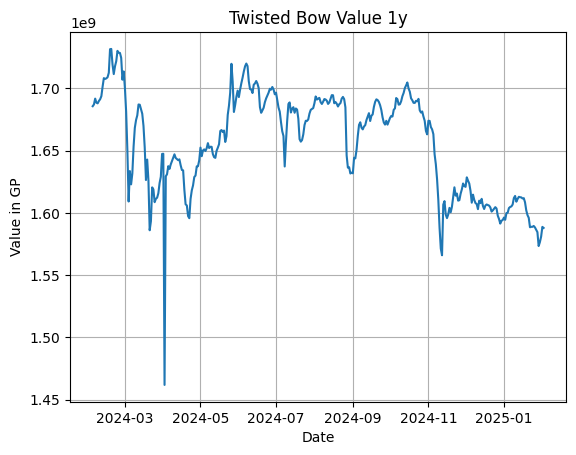

In [39]:
import matplotlib.pyplot as plt

plt.plot(df['timestamp'], df['avgLowPrice'])
plt.xlabel("Date")
plt.ylabel("Value in GP")
plt.title("Twisted Bow Value 1y")
plt.grid(True)
plt.show()

In [28]:
log_returns = np.log(df['avgLowPrice'] / df['avgLowPrice'].shift(1))
mu = log_returns.mean()
sigma = log_returns.std()

In [29]:
S0 = float(df.at[0, 'avgLowPrice'])
S0

1685770174.0

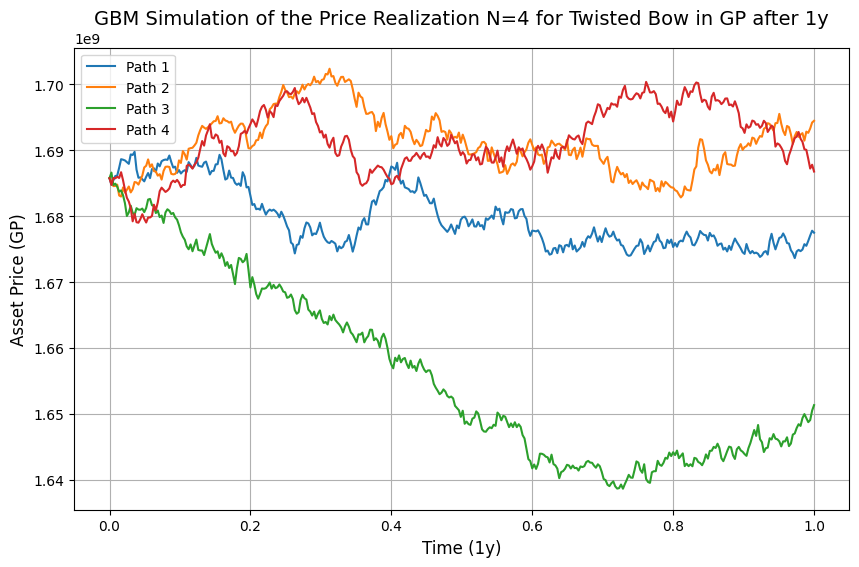

In [41]:
import numpy as np

T = 1
N = 365
M = 4
dt = T / N

dW = np.random.normal(0, np.sqrt(dt), size=(N, M))
W = np.vstack([np.zeros((1, M)), np.cumsum(dW, axis=0)])

t = np.linspace(0, T, N+1).reshape(-1, 1)
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

plt.figure(figsize=(10, 6))
plt.plot(t, S, linewidth=1.5)
plt.title('GBM Simulation of the Price Realization N=4 for Twisted Bow in GP after 1y', fontsize=14)
plt.xlabel('Time (1y)', fontsize=12)
plt.ylabel('Asset Price (GP)', fontsize=12)
plt.legend([f'Path {i+1}' for i in range(M)], loc='upper left')
plt.grid(True)
plt.show()

something to keep in mind here is that the simulations are kinda less accurate than I would like as there's not that many time steps in the data given over 1y timespan for our asset (twisted bow) 

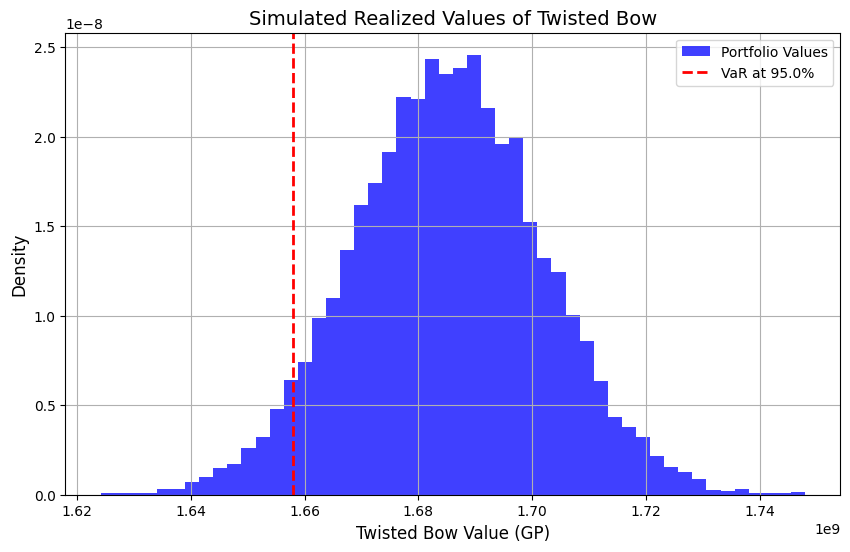

In [60]:
N = 10000
confidence = 0.95

# Utilizing Monte Carlo as well as GBM in order to simulate realized returns over 1y
returns = (mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.randn(N)
portfolio_values = S0 * np.exp(returns)
VaR = S0 - np.percentile(portfolio_values, 100 * (1 - confidence))

plt.figure(figsize=(10, 6))
plt.hist(portfolio_values, bins=50, density=True, alpha=0.75, color='blue', label='Portfolio Values')
plt.axvline(S0 - VaR, color='red', linestyle='--', linewidth=2, label=f'VaR at {confidence * 100}%')
plt.title('Simulated Realized Values of Twisted Bow', fontsize=14)
plt.xlabel('Twisted Bow Value (GP)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [65]:
print(f"Value at Risk: {float(VaR):.2f} GP")

Value at Risk: 27884503.75 GP


Yeah so what this kinda means is that within a 95% confidence interval you shouldn't lose more than 27 million GP by holding this twisted bow for another year, another way to put this is that there's a 1/20 chance of losing more than 27 million GP next year by holding the twisted bow

In [115]:
print(f"{log_returns.std() * np.sqrt(365) * 100:.2f}% Volitility")

18.82% Volitility


In [78]:
import yfinance as yf

msft = yf.Ticker('MSFT').history(start="2020-1-1", end="2020-12-1", interval="1d")
msft.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,151.870747,153.735890,151.440331,153.630676,22622100,0.0,0.0
2020-01-03 00:00:00-05:00,151.430809,152.989871,151.182113,151.717743,21116200,0.0,0.0
2020-01-06 00:00:00-05:00,150.244705,152.176809,149.699501,152.109848,20813700,0.0,0.0
2020-01-07 00:00:00-05:00,152.387236,152.721997,150.474265,150.722946,21634100,0.0,0.0
2020-01-08 00:00:00-05:00,152.014252,153.802891,151.076901,153.123779,27746500,0.0,0.0


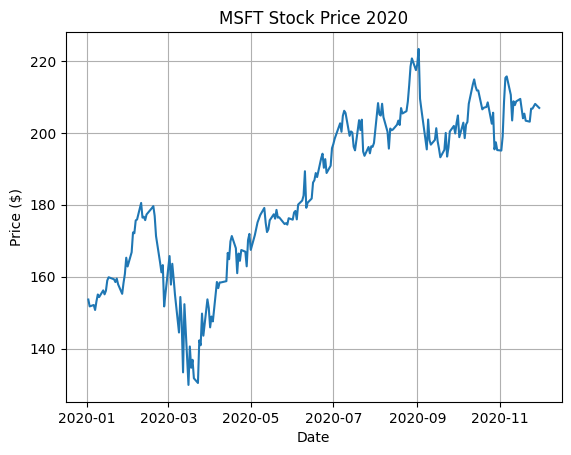

In [81]:
plt.plot(msft.index, msft['Close'])
plt.title("MSFT Stock Price 2020")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()

In [114]:
msft_returns = np.log(msft['Close'] / msft['Close'].shift(1)).std() * np.sqrt(252) # computing annualized volitility
print(f"Microsoft Realized Volitility for 2020: {msft_returns * 100:.2f}%")

Microsoft Realized Volitility for 2020: 45.85%


Something interesting to note here is why is it that the twisted bow is less volitile than microsoft? kinda weird, but I'm going to try this with fire runes which should be pretty volitile.

In [91]:
params = {
    "timestep": "24h",
    "id": "554" # Fire Rune
}

response = requests.get(base_url, params=params)
data = response.json()['data']

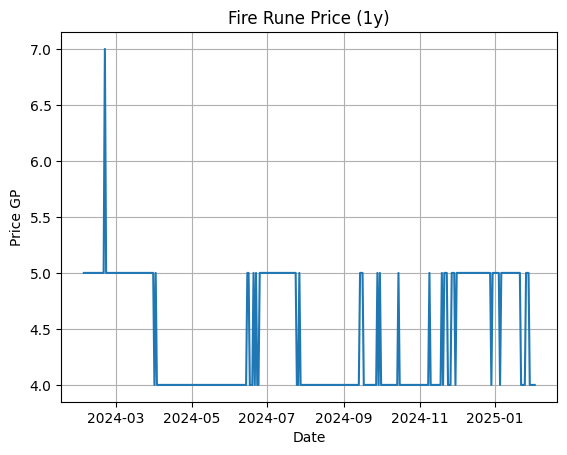

In [94]:
fire_rune = defaultdict(list)

for item in data:
    fire_rune['timestamp'].append(item['timestamp'])
    fire_rune['avgLowPrice'].append(item['avgLowPrice'])
    
fire_rune = pd.DataFrame(fire_rune)
fire_rune['timestamp'] = fire_rune['timestamp'].apply(datetime.fromtimestamp)
fire_rune['timestamp'] = fire_rune['timestamp'].apply(lambda x: x.date())

plt.plot(fire_rune['timestamp'], fire_rune['avgLowPrice'])
plt.xlabel('Date')
plt.ylabel('Price GP')
plt.grid(True)
plt.title('Fire Rune Price (1y)')
plt.show()

In [113]:
fire_rune_volitility = np.log(fire_rune['avgLowPrice'] / fire_rune['avgLowPrice'].shift(1)).std() * np.sqrt(365)
print(f"Fire Rune Realized Volitility: {fire_rune_volitility*100:.2f}%")

Fire Rune Realized Volitility: 144.22%


Absurd so options trading in runescape should go nuts surely?

In [99]:
tsla = yf.Ticker('TSLA').history(start="2024-1-1", end="2025-1-1", interval="1d")
tsla.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-02 00:00:00-05:00,250.080002,251.250000,244.410004,248.419998,104654200,0.0,0.0
2024-01-03 00:00:00-05:00,244.979996,245.679993,236.320007,238.449997,121082600,0.0,0.0
2024-01-04 00:00:00-05:00,239.250000,242.699997,237.729996,237.929993,102629300,0.0,0.0
2024-01-05 00:00:00-05:00,236.860001,240.119995,234.899994,237.490005,92379400,0.0,0.0
2024-01-08 00:00:00-05:00,236.139999,241.250000,235.300003,240.449997,85166600,0.0,0.0


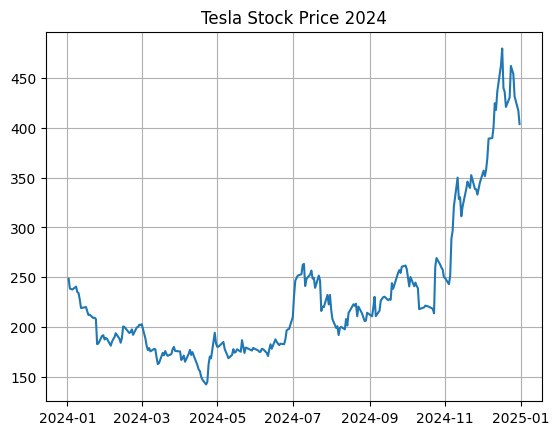

In [103]:
plt.plot(tsla.index, tsla['Close'])
plt.title("Tesla Stock Price 2024")
plt.grid(True)
plt.show()

In [116]:
print(f"Tesla Historic Realized Volitility: {np.log(tsla['Close'] / tsla['Close'].shift(1)).std() * np.sqrt(252) * 100:.2f}%")

Tesla Historic Realized Volitility: 62.62%
